In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
df.describe()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


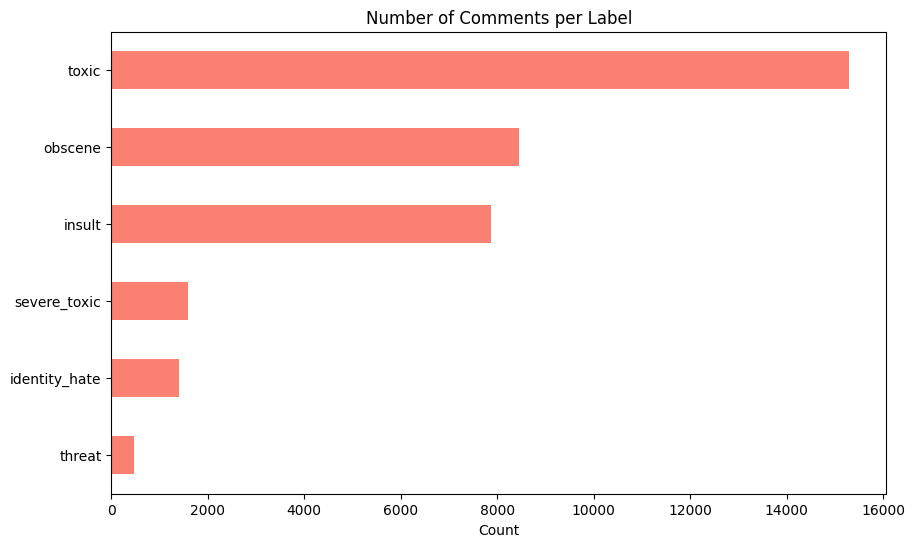

In [7]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df[labels].sum().sort_values().plot(kind='barh', figsize=(10,6), color='salmon')
plt.title("Number of Comments per Label")
plt.xlabel("Count")
plt.show()

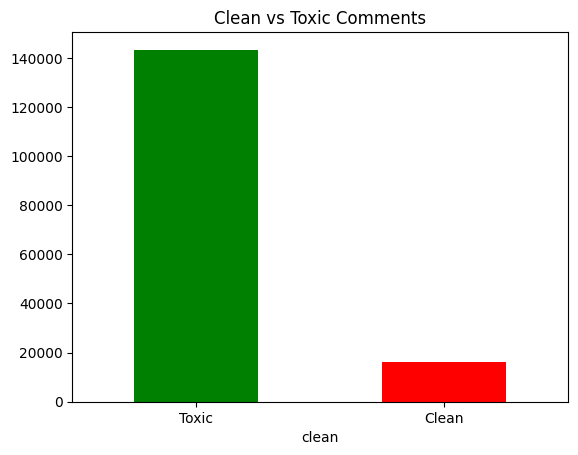

In [8]:
df['clean'] = (df[labels].sum(axis=1) == 0)
df['clean'].value_counts().plot(kind='bar', color=['green','red'])
plt.title("Clean vs Toxic Comments")
plt.xticks([0, 1], ['Toxic', 'Clean'], rotation=0)
plt.show()

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

# Instantiate lemmatizer once for efficiency
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # lowercase
    text = text.lower()

    # expand contractions
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)

    # remove non-letters
    text = re.sub('[^a-zA-Z]', ' ', text)

    # remove extra spaces (fixed SyntaxWarning with r'\s+')
    text = re.sub(r'\s+', ' ', text).strip()

    # remove stopwords
    stoplist = set(stopwords.words('english'))
    words = [word for word in text.split() if word not in stoplist]

    # lemmatization using the globally instantiated lemmatizer
    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)

df['comment_text'] = df['comment_text'].fillna('').apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
from sklearn.model_selection import train_test_split

X = df['comment_text']
y = df[labels]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(LogisticRegression(max_iter=200))
model.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=200))

In [14]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test_vec)

for i, label in enumerate(labels):
    print(f"\nLabel: {label}")
    print(classification_report(y_test[label], y_pred[:, i]))


Label: toxic
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.90      0.64      0.74      3056

    accuracy                           0.96     31915
   macro avg       0.93      0.81      0.86     31915
weighted avg       0.96      0.96      0.96     31915


Label: severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31594
           1       0.58      0.27      0.37       321

    accuracy                           0.99     31915
   macro avg       0.79      0.63      0.68     31915
weighted avg       0.99      0.99      0.99     31915


Label: obscene
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     30200
           1       0.92      0.64      0.76      1715

    accuracy                           0.98     31915
   macro avg       0.95      0.82      0.87     31915
weighted avg       0.98

In [15]:
comment = ["I are handsome"]
comment_clean = [clean_text(comment[0])]
vec = vectorizer.transform(comment_clean)
model.predict(vec)
prediction = model.predict(vec)[0]
predicted_toxicities = []
for i, value in enumerate(prediction):
    if value == 1:
        predicted_toxicities.append(labels[i])

if predicted_toxicities:
    print(f"The comment is predicted to be: {', '.join(predicted_toxicities)}")
else:
    print("The comment is predicted to be clean.")

The comment is predicted to be clean.


In [16]:
#random forest
from sklearn.ensemble import RandomForestClassifier

model_rf = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced'))
model_rf.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced'))

In [17]:
y_pred = model_rf.predict(X_test_vec)

for i, label in enumerate(labels):
    print(f"\nLabel: {label}")
    print(classification_report(y_test[label], y_pred[:, i]))


Label: toxic
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28859
           1       0.82      0.61      0.70      3056

    accuracy                           0.95     31915
   macro avg       0.89      0.80      0.84     31915
weighted avg       0.95      0.95      0.95     31915


Label: severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     31594
           1       0.42      0.22      0.29       321

    accuracy                           0.99     31915
   macro avg       0.70      0.61      0.64     31915
weighted avg       0.99      0.99      0.99     31915


Label: obscene
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     30200
           1       0.77      0.65      0.71      1715

    accuracy                           0.97     31915
   macro avg       0.88      0.82      0.85     31915
weighted avg       0.97

In [18]:
comment = ["I are handsome"]
comment_clean = [clean_text(comment[0])]
vec = vectorizer.transform(comment_clean)
model_rf.predict(vec)
prediction = model_rf.predict(vec)[0]
predicted_toxicities = []
for i, value in enumerate(prediction):
    if value == 1:
        predicted_toxicities.append(labels[i])

if predicted_toxicities:
    print(f"The comment is predicted to be: {', '.join(predicted_toxicities)}")
else:
    print("The comment is predicted to be clean.")

The comment is predicted to be: toxic, obscene, insult, identity_hate


In [19]:
 #svc
from sklearn.svm import SVC

model_svc = OneVsRestClassifier(SVC())
model_svc.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=SVC())

In [20]:
y_pred = model_svc.predict(X_test_vec)

for i, label in enumerate(labels):
    print(f"\nLabel: {label}")
    print(classification_report(y_test[label], y_pred[:, i]))


Label: toxic
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.91      0.64      0.75      3056

    accuracy                           0.96     31915
   macro avg       0.94      0.82      0.87     31915
weighted avg       0.96      0.96      0.96     31915


Label: severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     31594
           1       0.53      0.08      0.14       321

    accuracy                           0.99     31915
   macro avg       0.76      0.54      0.57     31915
weighted avg       0.99      0.99      0.99     31915


Label: obscene
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     30200
           1       0.90      0.68      0.77      1715

    accuracy                           0.98     31915
   macro avg       0.94      0.84      0.88     31915
weighted avg       0.98

In [24]:
comment = ["You are fucking dumb"]
comment_clean = [clean_text(comment[0])]
vec = vectorizer.transform(comment_clean)
model_svc.predict(vec)
prediction = model_svc.predict(vec)[0]
predicted_toxicities = []
for i, value in enumerate(prediction):
    if value == 1:
        predicted_toxicities.append(labels[i])

if predicted_toxicities:
    print(f"The comment is predicted to be: {', '.join(predicted_toxicities)}")
else:
    print("The comment is predicted to be clean.")

The comment is predicted to be: toxic, obscene, insult


In [23]:
#navie
from sklearn.naive_bayes import MultinomialNB

model_nb = OneVsRestClassifier(MultinomialNB())
model_nb.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [26]:
y_pred = model_nb.predict(X_test_vec)

for i, label in enumerate(labels):
    print(f"\nLabel: {label}")
    print(classification_report(y_test[label], y_pred[:, i]))


Label: toxic
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     28859
           1       0.93      0.52      0.66      3056

    accuracy                           0.95     31915
   macro avg       0.94      0.76      0.82     31915
weighted avg       0.95      0.95      0.94     31915


Label: severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31594
           1       0.69      0.10      0.18       321

    accuracy                           0.99     31915
   macro avg       0.84      0.55      0.59     31915
weighted avg       0.99      0.99      0.99     31915


Label: obscene
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     30200
           1       0.91      0.50      0.65      1715

    accuracy                           0.97     31915
   macro avg       0.94      0.75      0.82     31915
weighted avg       0.97

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
comment = ["You are fucking dumb"]
comment_clean = [clean_text(comment[0])]
vec = vectorizer.transform(comment_clean)
model_nb.predict(vec)
prediction = model_nb.predict(vec)[0]
predicted_toxicities = []
for i, value in enumerate(prediction):
    if value == 1:
        predicted_toxicities.append(labels[i])

if predicted_toxicities:
    print(f"The comment is predicted to be: {', '.join(predicted_toxicities)}")
else:
    print("The comment is predicted to be clean.")

The comment is predicted to be: toxic, obscene, insult
